In [213]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold, GridSearchCV,\
cross_val_score, RandomizedSearchCV,cross_validate
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import f1_score, confusion_matrix, recall_score, precision_score, accuracy_score
from sklearn.metrics import plot_confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import RFE, RFECV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
import sklearn 
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors
from matplotlib import pyplot
from xgboost import plot_importance
from sklearn import metrics
from fast_ml.model_development import train_valid_test_split

#for the Neural Network
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.wrappers import scikit_learn
from tensorflow.keras.callbacks import EarlyStopping
from keras.constraints import maxnorm


In [139]:
Vegas_Odds = pd.read_excel('nba odds 2020-21 Update.xlsx')
Game_Log = pd.read_csv('games.csv')
Teams = pd.read_csv('teams.csv')

# Cleaning the Data

In [140]:
Vegas_Odds

Date VH         Team  Final   Open  Close
0    2020-12-22  V  GoldenState     99    228  234.5
1    2020-12-22  H     Brooklyn    125    5.5    7.5
2    2020-12-22  V   LAClippers    116    223    219
3    2020-12-22  H     LALakers    109    2.5      2
4    2020-12-23  V    Charlotte    114    215      3
...         ... ..          ...    ...    ...    ...
2155 2021-05-16  H   Washington    115    6.5      7
2156 2021-05-16  V       Boston     92  215.5    211
2157 2021-05-16  H      NewYork     96    8.5     12
2158 2021-05-16  V      Indiana    125      7      6
2159 2021-05-16  H      Toronto    113  229.5  226.5

[2160 rows x 6 columns]

In [141]:
Vegas_Odds.isna().mean()

Date     0.0
VH       0.0
Team     0.0
Final    0.0
Open     0.0
Close    0.0
dtype: float64

Splitting Dataframe based on home team or away team

In [142]:
Vegas_Odds_Home =  Vegas_Odds[Vegas_Odds['VH'] == 'H']
Vegas_Odds_Visitor =  Vegas_Odds[Vegas_Odds['VH'] == 'V']

In [143]:
Vegas_Odds_Home.rename(columns={'Team':'Home_Team','Final':'Home_Score','Open':'HOpen','Close':'HClose'},inplace=True)

In [144]:
Vegas_Odds_Visitor.rename(columns={'Team':'Visitor_Team','Final':'Visitor_Score','Open':'VOpen','Close':'VClose'},inplace=True)

In [145]:
Vegas_Odds_Home.insert(0,'index',range(0+ len(Vegas_Odds_Home)))

In [146]:
Vegas_Odds_Home.set_index('index',inplace=True)

In [147]:
Vegas_Odds_Visitor.insert(0,'index',range(0+ len(Vegas_Odds_Visitor)))

In [148]:
Vegas_Odds_Visitor.set_index('index',inplace=True)

Merging the dataframes back together

In [149]:
Vegas_Final = pd.merge(Vegas_Odds_Home,Vegas_Odds_Visitor, left_index=True, right_index=True,how='outer')

In [150]:
Vegas_Final.set_index('Date_x',inplace=True)

In [151]:
Vegas_Final = Vegas_Final[['Home_Team','Visitor_Team','Home_Score',
                          'Visitor_Score','HOpen','HClose','VOpen','VClose']]

Creating opening and closing spread bet columns

In [152]:
Vegas_Final['HOpen'] = np.where((Vegas_Final['HOpen'] == 'pk'),0,Vegas_Final['HOpen'])
Vegas_Final['HClose'] = np.where((Vegas_Final['HClose'] == 'pk'),0,Vegas_Final['HClose'])
Vegas_Final['VOpen'] = np.where((Vegas_Final['VOpen'] == 'pk'),0,Vegas_Final['VOpen'])
Vegas_Final['VClose'] = np.where((Vegas_Final['VClose'] == 'pk'),0,Vegas_Final['VClose'])

In [153]:
def spread(row,x):
    if row['HOpen'] < x:
        return row['HOpen']
    else:
        return (row['VOpen']*-1) 

In [154]:
Vegas_Final['OSpread'] = Vegas_Final.apply(lambda row: spread(row,20),axis=1)

In [155]:
def Cspread(row,x):
    if row['HClose'] < x:
        return row['HClose']
    else:
        return (row['VClose']*-1) 

In [156]:
Vegas_Final['CSpread'] = Vegas_Final.apply(lambda row: Cspread(row,20),axis=1)

Creating a point differential column

In [157]:
Vegas_Final['PointDiff'] = Vegas_Final['Home_Score'] - Vegas_Final['Visitor_Score']

Home team wins column

In [158]:
Vegas_Final['Home_Win'] = np.where(Vegas_Final.Home_Score > Vegas_Final.Visitor_Score,
                                  1, 0)

Spread is won column

In [159]:
Vegas_Final['OSpreadWin'] = np.where(Vegas_Final.PointDiff > Vegas_Final['OSpread'],1, 0)
Vegas_Final['CSpreadWin'] = np.where(Vegas_Final.PointDiff > Vegas_Final['CSpread'],1, 0)

In [160]:
def conditions(s):
    if (s['OSpreadWin'] == 1) & (s['CSpreadWin'] == 1):
        return 1
    else:
        return 0

In [161]:
Vegas_Final['SpreadW'] = Vegas_Final.apply(lambda s: conditions(s),axis=1)

In [162]:
Vegas_Final['Home_Team'].unique()

array(['Brooklyn', 'LALakers', 'Cleveland', 'Indiana', 'Orlando',
       'Philadelphia', 'Boston', 'Toronto', 'Chicago', 'Memphis',
       'Minnesota', 'Denver', 'Portland', 'Phoenix', 'Miami', 'Milwaukee',
       'Detroit', 'Washington', 'Charlotte', 'NewYork', 'SanAntonio',
       'Utah', 'Sacramento', 'LAClippers', 'NewOrleans', 'Atlanta',
       'OklahomaCity', 'Dallas', 'Houston', 'GoldenState'], dtype=object)

Dictionary created to rename teams

In [163]:
NBA_TTA = {'Brooklyn':'Nets','LALakers':'Lakers','Cleveland':'Cavaliers','Indiana':'Pacers',
          'Orlando':'Magic',
 'Philadelphia':'76ers',
 'Boston':'Celtics',
 'Toronto':'Raptors',
 'Chicago':'Bulls',
 'Memphis':'Grizzlies',
 'Minnesota':'Timberwolves',
 'Denver':'Nuggets',
 'Portland':'Trail Blazers',
 'Phoenix':'Suns',
 'Miami':'Heat',
 'Milwaukee':'Bucks',
 'Detroit':'Pistons',
 'Washington':'Wizards',
 'Charlotte':'Hornets',
 'NewYork':'Knicks',
 'SanAntonio':'Spurs',
 'Utah':'Jazz',
 'Sacramento':'Kings',
 'LAClippers':'Clippers',
 'NewOrleans':'Pelicans',
 'Atlanta':'Hawks',
 'OklahomaCity':'Thunder',
 'Dallas':'Mavericks',
 'Houston':'Rockets',
 'GoldenState':'Warriors'}
Vegas_Final.Home_Team = Vegas_Final.Home_Team.map(NBA_TTA)
Vegas_Final.Visitor_Team = Vegas_Final.Visitor_Team.map(NBA_TTA)

In [164]:
Vegas_Final

Home_Team Visitor_Team  Home_Score  Visitor_Score  HOpen  \
Date_x                                                                     
2020-12-22           Nets     Warriors         125             99    5.5   
2020-12-22         Lakers     Clippers         109            116    2.5   
2020-12-23      Cavaliers      Hornets         121            114      1   
2020-12-23         Pacers       Knicks         121            107    8.5   
2020-12-23          Magic         Heat         113            107  220.5   
...                   ...          ...         ...            ...    ...   
2021-05-16  Trail Blazers      Nuggets         132            116    8.5   
2021-05-16          Bulls        Bucks         118            112  224.5   
2021-05-16        Wizards      Hornets         115            110    6.5   
2021-05-16         Knicks      Celtics          96             92    8.5   
2021-05-16        Raptors       Pacers         113            125  229.5   

           HClose  VOpen VClose  OSpread  CSpread  PointDiff  Home_Win  \
Date_x                                                                   
2020-12-22    7.5    228  234.5      5.5      7.5         26         1   
2020-12-22      2    223    219      2.5      2.0         -7         0   
2020-12-23    217    215      3      1.0     -3.0          7         1   
2020-12-23    7.5  214.5  215.5      8.5      7.5         14         1   
2020-12-23    219    3.5    4.5     -3.5     -4.5          6         1   
...           ...    ...    ...      ...      ...        ...       ...   
2021-05-16    8.5  230.5  228.5      8.5      8.5         16         1   
2021-05-16  224.5    2.5      7     -2.5     -7.0          6         1   
2021-05-16      7  228.5  230.5      6.5      7.0          5         1   
2021-05-16     12  215.5    211      8.5     12.0          4         1   
2021-05-16  226.5      7      6     -7.0     -6.0        -12         0   

            OSpreadWin  CSpreadWin  SpreadW  
Date_x                                       
2020-12-22           1           1        1  
2020-12-22           0           0        0  
2020-12-23           1           1        1  
2020-12-23           1           1        1  
2020-12-23           1           1        1  
...                ...         ...      ...  
2021-05-16           1           1        1  
2021-05-16           1           1        1  
2021-05-16           0           0        0  
2021-05-16           0           0        0  
2021-05-16           0           0        0  

[1080 rows x 15 columns]

Regular Season game Dataframe

In [165]:
REGSEASON = Game_Log.loc[(Game_Log.GAME_DATE_EST >= '2020-12-22') & (Game_Log.GAME_DATE_EST <= '2021-05-16') ]
REGSEASON.sort_values('GAME_DATE_EST')

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
552     2020-12-22  22000002            Final    1610612747       1610612746   
551     2020-12-22  22000001            Final    1610612751       1610612744   
1156    2020-12-23  22000004            Final    1610612756       1610612742   
1155    2020-12-23  22000018            Final    1610612750       1610612765   
550     2020-12-23  22000004            Final    1610612756       1610612742   
...            ...       ...              ...           ...              ...   
34      2021-05-16  22001074            Final    1610612760       1610612746   
35      2021-05-16  22001076            Final    1610612757       1610612743   
36      2021-05-16  22001077            Final    1610612758       1610612762   
29      2021-05-16  22001075            Final    1610612755       1610612753   
22      2021-05-16  22001073            Final    1610612752       1610612738   

      SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  AST_home  \
552     2020    1610612747     109.0        0.469        0.774  ...      22.0   
551     2020    1610612751     125.0        0.457        0.813  ...      24.0   
1156    2020    1610612756     106.0        0.481        0.704  ...      21.0   
1155    2020    1610612750     111.0        0.432        0.857  ...      25.0   
550     2020    1610612756     106.0        0.481        0.704  ...      21.0   
...      ...           ...       ...          ...          ...  ...       ...   
34      2020    1610612760     117.0        0.532        0.563  ...      20.0   
35      2020    1610612757     132.0        0.529        0.846  ...      24.0   
36      2020    1610612758      99.0        0.467        0.600  ...      24.0   
29      2020    1610612755     128.0        0.489        0.739  ...      35.0   
22      2020    1610612752      96.0        0.430        0.789  ...      16.0   

      REB_home  TEAM_ID_away  PTS_away  FG_PCT_away  FT_PCT_away  \
552       45.0    1610612746     116.0        0.473        0.737   
551       57.0    1610612744      99.0        0.374        0.652   
1156      48.0    1610612742     102.0        0.424        0.808   
1155      48.0    1610612765     101.0        0.484        0.375   
550       48.0    1610612742     102.0        0.424        0.808   
...        ...           ...       ...          ...          ...   
34        54.0    1610612746     112.0        0.425        0.800   
35        51.0    1610612743     116.0        0.449        0.933   
36        39.0    1610612762     121.0        0.477        0.840   
29        41.0    1610612753     117.0        0.474        0.854   
22        41.0    1610612738      92.0        0.407        0.733   

      FG3_PCT_away  AST_away  REB_away  HOME_TEAM_WINS  
552          0.350      22.0      40.0               0  
551          0.303      26.0      47.0               1  
1156         0.243      17.0      39.0               1  
1155         0.229      29.0      44.0               1  
550          0.243      17.0      39.0               1  
...            ...       ...       ...             ...  
34           0.233      17.0      44.0               1  
35           0.378      20.0      36.0               1  
36           0.462      28.0      50.0               0  
29           0.357      23.0      47.0               1  
22           0.268      19.0      46.0               1  

[1135 rows x 21 columns]

In [166]:
REGSEASON.columns

Index(['GAME_DATE_EST', 'GAME_ID', 'GAME_STATUS_TEXT', 'HOME_TEAM_ID',
       'VISITOR_TEAM_ID', 'SEASON', 'TEAM_ID_home', 'PTS_home', 'FG_PCT_home',
       'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home', 'TEAM_ID_away',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away', 'HOME_TEAM_WINS'],
      dtype='object')

In [167]:
REGSEASON.drop_duplicates(['GAME_ID'],keep='first',inplace=True)

In [168]:
H = REGSEASON.merge(Teams[['TEAM_ID','NICKNAME']],left_on=['HOME_TEAM_ID'],right_on=['TEAM_ID'])
A = H.merge(Teams[['TEAM_ID','NICKNAME']],left_on=['VISITOR_TEAM_ID'],right_on=['TEAM_ID'])
A

GAME_DATE_EST   GAME_ID GAME_STATUS_TEXT  HOME_TEAM_ID  VISITOR_TEAM_ID  \
0       2021-05-16  22001073            Final    1610612752       1610612738   
1       2021-01-04  22000097            Final    1610612761       1610612738   
2       2021-02-14  22000560            Final    1610612764       1610612738   
3       2021-01-27  22000280            Final    1610612759       1610612738   
4       2021-02-02  22000326            Final    1610612744       1610612738   
...            ...       ...              ...           ...              ...   
1075    2021-04-07  22000778            Final    1610612738       1610612752   
1076    2021-01-17  22000196            Final    1610612738       1610612752   
1077    2021-05-09  22001019            Final    1610612746       1610612752   
1078    2021-02-17  22000436            Final    1610612753       1610612752   
1079    2021-05-05  22000995            Final    1610612743       1610612752   

      SEASON  TEAM_ID_home  PTS_home  FG_PCT_home  FT_PCT_home  ...  \
0       2020    1610612752      96.0        0.430        0.789  ...   
1       2020    1610612761     114.0        0.400        0.763  ...   
2       2020    1610612764     104.0        0.398        0.861  ...   
3       2020    1610612759     110.0        0.561        0.625  ...   
4       2020    1610612744     107.0        0.458        0.696  ...   
...      ...           ...       ...          ...          ...  ...   
1075    2020    1610612738     101.0        0.419        0.700  ...   
1076    2020    1610612738      75.0        0.298        0.621  ...   
1077    2020    1610612746     100.0        0.430        0.875  ...   
1078    2020    1610612753     107.0        0.457        0.700  ...   
1079    2020    1610612743     113.0        0.381        0.818  ...   

      FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  \
0           0.407        0.733         0.268      19.0      46.0   
1           0.488        0.853         0.517      19.0      56.0   
2           0.356        0.600         0.257      14.0      50.0   
3           0.429        0.857         0.333      15.0      39.0   
4           0.464        0.741         0.382      16.0      51.0   
...           ...          ...           ...       ...       ...   
1075        0.417        0.813         0.485      22.0      39.0   
1076        0.475        0.810         0.387      22.0      53.0   
1077        0.467        1.000         0.406      25.0      45.0   
1078        0.379        0.842         0.259      16.0      46.0   
1079        0.384        0.667         0.371      18.0      42.0   

      HOME_TEAM_WINS   TEAM_ID_x  NICKNAME_x   TEAM_ID_y  NICKNAME_y  
0                  1  1610612752      Knicks  1610612738     Celtics  
1                  0  1610612761     Raptors  1610612738     Celtics  
2                  1  1610612764     Wizards  1610612738     Celtics  
3                  1  1610612759       Spurs  1610612738     Celtics  
4                  0  1610612744    Warriors  1610612738     Celtics  
...              ...         ...         ...         ...         ...  
1075               1  1610612738     Celtics  1610612752      Knicks  
1076               0  1610612738     Celtics  1610612752      Knicks  
1077               0  1610612746    Clippers  1610612752      Knicks  
1078               1  1610612753       Magic  1610612752      Knicks  
1079               1  1610612743     Nuggets  1610612752      Knicks  

[1080 rows x 25 columns]

In [169]:
B = A.drop(['TEAM_ID_x','TEAM_ID_y','GAME_STATUS_TEXT','HOME_TEAM_ID',
       'VISITOR_TEAM_ID','SEASON', 'TEAM_ID_home','TEAM_ID_away'],axis=1)

In [170]:
B.rename(columns={'NICKNAME_x':'Home','NICKNAME_y':'Away'},inplace=True)
B = B[['GAME_DATE_EST', 'GAME_ID','Home', 'Away','PTS_home', 'FG_PCT_home', 'FT_PCT_home',
       'FG3_PCT_home', 'AST_home', 'REB_home', 'PTS_away', 'FG_PCT_away',
       'FT_PCT_away', 'FG3_PCT_away', 'AST_away', 'REB_away','HOME_TEAM_WINS']]

In [171]:
SemiDF = Vegas_Final.merge(B,left_on=['Home_Team','Visitor_Team','Visitor_Score','Home_Score'],right_on=['Home','Away',
                                                                                                          'PTS_away','PTS_home'])

In [172]:
FinalDF = SemiDF.drop(columns=[
         'Home','Away','HOpen', 'HClose', 'VOpen', 'VClose','OSpreadWin', 'CSpreadWin',
       'HOME_TEAM_WINS'])

In [173]:
FinalDF['GAME_DATE_EST'] = pd.to_datetime(FinalDF['GAME_DATE_EST'])
FinalDF.set_index('GAME_DATE_EST')

Home_Team Visitor_Team  Home_Score  Visitor_Score  OSpread  \
GAME_DATE_EST                                                                   
2020-12-22              Nets     Warriors         125             99      5.5   
2020-12-22            Lakers     Clippers         109            116      2.5   
2020-12-23         Cavaliers      Hornets         121            114      1.0   
2020-12-23            Pacers       Knicks         121            107      8.5   
2020-12-23             Magic         Heat         113            107     -3.5   
...                      ...          ...         ...            ...      ...   
2021-05-16     Trail Blazers      Nuggets         132            116      8.5   
2021-05-16             Bulls        Bucks         118            112     -2.5   
2021-05-16           Wizards      Hornets         115            110      6.5   
2021-05-16            Knicks      Celtics          96             92      8.5   
2021-05-16           Raptors       Pacers         113            125     -7.0   

               CSpread  PointDiff  Home_Win  SpreadW   GAME_ID  ...  \
GAME_DATE_EST                                                   ...   
2020-12-22         7.5         26         1        1  22000001  ...   
2020-12-22         2.0         -7         0        0  22000002  ...   
2020-12-23        -3.0          7         1        1  22000010  ...   
2020-12-23         7.5         14         1        1  22000011  ...   
2020-12-23        -4.5          6         1        1  22000012  ...   
...                ...        ...       ...      ...       ...  ...   
2021-05-16         8.5         16         1        1  22001076  ...   
2021-05-16        -7.0          6         1        1  22001068  ...   
2021-05-16         7.0          5         1        0  22001080  ...   
2021-05-16        12.0          4         1        0  22001073  ...   
2021-05-16        -6.0        -12         0        0  22001079  ...   

               FT_PCT_home  FG3_PCT_home  AST_home  REB_home  PTS_away  \
GAME_DATE_EST                                                            
2020-12-22           0.813         0.429      24.0      57.0      99.0   
2020-12-22           0.774         0.310      22.0      45.0     116.0   
2020-12-23           0.750         0.467      34.0      50.0     114.0   
2020-12-23           0.724         0.235      28.0      50.0     107.0   
2020-12-23           0.633         0.357      23.0      41.0     107.0   
...                    ...           ...       ...       ...       ...   
2021-05-16           0.846         0.419      24.0      51.0     116.0   
2021-05-16           0.737         0.438      23.0      45.0     112.0   
2021-05-16           0.810         0.323      22.0      53.0     110.0   
2021-05-16           0.789         0.481      16.0      41.0      92.0   
2021-05-16           0.793         0.316      21.0      48.0     125.0   

               FG_PCT_away  FT_PCT_away  FG3_PCT_away  AST_away  REB_away  
GAME_DATE_EST                                                              
2020-12-22           0.374        0.652         0.303      26.0      47.0  
2020-12-22           0.473        0.737         0.350      22.0      40.0  
2020-12-23           0.500        0.533         0.364      29.0      32.0  
2020-12-23           0.459        0.739         0.429      25.0      40.0  
2020-12-23           0.506        0.842         0.350      25.0      43.0  
...                    ...          ...           ...       ...       ...  
2021-05-16           0.449        0.933         0.378      20.0      36.0  
2021-05-16           0.422        0.750         0.324      14.0      41.0  
2021-05-16           0.394        0.917         0.311      25.0      42.0  
2021-05-16           0.407        0.733         0.268      19.0      46.0  
2021-05-16           0.505        0.778         0.405      34.0      47.0  

[1080 rows x 22 columns]

# EDA

In [38]:
FinalDF.describe()

Home_Score  Visitor_Score      OSpread      CSpread    PointDiff  \
count  1080.000000    1080.000000  1080.000000  1080.000000  1080.000000   
mean    112.562963     111.619444     1.415278     1.229167     0.943519   
std      12.454987      12.546728     6.407501     6.580297    15.184365   
min      73.000000      75.000000   -14.500000   -15.000000   -57.000000   
25%     104.000000     103.000000    -4.000000    -4.000000    -9.000000   
50%     112.000000     111.000000     2.500000     2.000000     2.000000   
75%     121.000000     120.000000     6.500000     6.500000    11.000000   
max     154.000000     154.000000    17.000000    19.000000    53.000000   

          Home_Win      SpreadW       GAME_ID     PTS_home  FG_PCT_home  \
count  1080.000000  1080.000000  1.080000e+03  1080.000000  1080.000000   
mean      0.543519     0.462963  2.200054e+07   112.562963     0.468882   
std       0.498333     0.498857  3.119134e+02    12.454987     0.054863   
min       0.000000     0.000000  2.200000e+07    73.000000     0.277000   
25%       0.000000     0.000000  2.200027e+07   104.000000     0.430000   
50%       1.000000     0.000000  2.200054e+07   112.000000     0.468000   
75%       1.000000     1.000000  2.200081e+07   121.000000     0.506000   
max       1.000000     1.000000  2.200108e+07   154.000000     0.654000   

       FT_PCT_home  FG3_PCT_home     AST_home     REB_home     PTS_away  \
count  1080.000000   1080.000000  1080.000000  1080.000000  1080.000000   
mean      0.779627      0.368510    24.974074    44.716667   111.619444   
std       0.101963      0.084751     4.970466     6.390106    12.546728   
min       0.333000      0.089000    10.000000    24.000000    75.000000   
25%       0.717750      0.313000    22.000000    40.000000   103.000000   
50%       0.786000      0.368000    25.000000    45.000000   111.000000   
75%       0.846000      0.429000    28.000000    49.000000   120.000000   
max       1.000000      0.645000    50.000000    70.000000   154.000000   

       FG_PCT_away  FT_PCT_away  FG3_PCT_away     AST_away     REB_away  
count  1080.000000  1080.000000   1080.000000  1080.000000  1080.000000  
mean      0.464963     0.777484      0.362280    24.634259    43.879630  
std       0.053323     0.103558      0.086011     4.960692     6.378279  
min       0.314000     0.316000      0.083000    10.000000    27.000000  
25%       0.427000     0.714000      0.308000    21.000000    39.000000  
50%       0.464000     0.783000      0.359000    25.000000    44.000000  
75%       0.500000     0.850500      0.421250    28.000000    48.000000  
max       0.655000     1.000000      0.636000    41.000000    65.000000

<AxesSubplot:xlabel='Home_Team'>

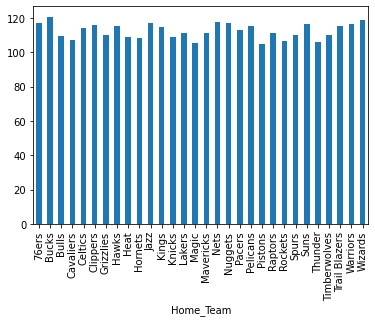

In [39]:
FinalDF.groupby('Home_Team')['Home_Score'].mean().plot.bar()

In [60]:
grouped_df_h = FinalDF.groupby(['Home_Team','SpreadW'])['Home_Score'].mean()

In [67]:
grouped_df_v=FinalDF.groupby(['Visitor_Team','SpreadW'])['Visitor_Score'].mean()

In [65]:
pd.DataFrame(grouped_df_h)

Home_Score
Home_Team     SpreadW            
76ers         0        112.411765
              1        121.947368
Bucks         0        115.684211
              1        126.470588
Bulls         0        102.476190
              1        119.200000
Cavaliers     0        101.409091
              1        117.000000
Celtics       0        111.105263
              1        117.411765
Clippers      0        106.266667
              1        122.857143
Grizzlies     0        107.352941
              1        112.421053
Hawks         0        109.307692
              1        118.869565
Heat          0        105.181818
              1        115.142857
Hornets       0        103.176471
              1        113.052632
Jazz          0        110.538462
              1        121.347826
Kings         0        112.086957
              1        120.076923
Knicks        0         98.285714
              1        116.272727
Lakers        0        108.304348
              1        117.000000
Magic         0        101.227273
              1        112.000000
Mavericks     0        111.095238
              1        111.000000
Nets          0        114.176471
              1        121.052632
Nuggets       0        113.900000
              1        121.062500
Pacers        0        109.703704
              1        122.222222
Pelicans      0        110.650000
              1        120.750000
Pistons       0         99.526316
              1        111.294118
Raptors       0        108.272727
              1        115.500000
Rockets       0        102.925926
              1        117.666667
Spurs         0        107.000000
              1        114.866667
Suns          0        114.857143
              1        117.590909
Thunder       0        101.916667
              1        113.916667
Timberwolves  0        107.000000
              1        113.705882
Trail Blazers 0        112.857143
              1        118.733333
Warriors      0        106.285714
              1        122.818182
Wizards       0        112.823529
              1        124.526316

In [69]:
pd.DataFrame(grouped_df_v)

Visitor_Score
Visitor_Team  SpreadW               
76ers         0           114.473684
              1           104.647059
Bucks         0           123.187500
              1           116.500000
Bulls         0           115.875000
              1           104.000000
Cavaliers     0           107.666667
              1            96.458333
Celtics       0           116.529412
              1           106.368421
Clippers      0           116.421053
              1           107.235294
Grizzlies     0           122.590909
              1           107.071429
Hawks         0           117.411765
              1           107.105263
Heat          0           112.263158
              1           101.294118
Hornets       0           116.529412
              1           105.157895
Jazz          0           118.777778
              1           112.000000
Kings         0           115.333333
              1           108.533333
Knicks        0           109.347826
              1            96.692308
Lakers        0           113.900000
              1            99.812500
Magic         0           111.176471
              1            94.894737
Mavericks     0           119.000000
              1           107.375000
Nets          0           124.473684
              1           113.588235
Nuggets       0           116.526316
              1           109.117647
Pacers        0           121.136364
              1           112.500000
Pelicans      0           119.000000
              1           107.875000
Pistons       0           113.947368
              1           101.647059
Raptors       0           117.875000
              1           106.300000
Rockets       0           119.277778
              1           102.666667
Spurs         0           116.458333
              1           102.750000
Suns          0           118.095238
              1           108.333333
Thunder       0           109.666667
              1            96.266667
Timberwolves  0           118.600000
              1           108.437500
Trail Blazers 0           121.782609
              1           108.307692
Warriors      0           120.142857
              1           105.227273
Wizards       0           119.434783
              1           105.153846

In [126]:
FinalDF.columns

Index(['Home_Team', 'Visitor_Team', 'Home_Score', 'Visitor_Score', 'OSpread',
       'CSpread', 'PointDiff', 'Home_Win', 'SpreadW', 'GAME_DATE_EST',
       'GAME_ID', 'PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home',
       'AST_home', 'REB_home', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away',
       'FG3_PCT_away', 'AST_away', 'REB_away'],
      dtype='object')

Text(0.5, 1.0, 'Closing Spread vs Point Differential')

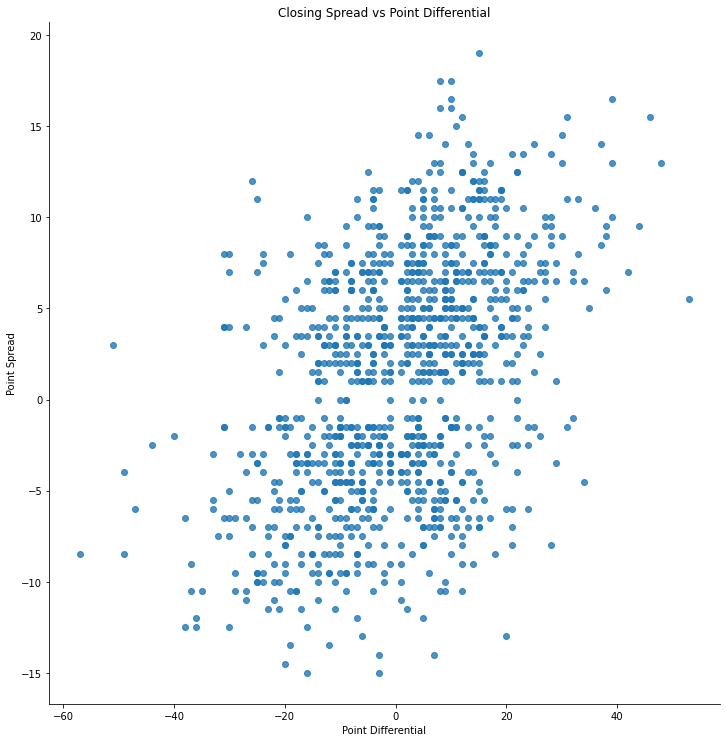

In [91]:
ax = sns.lmplot(y='CSpread',x='PointDiff',data=FinalDF,fit_reg=False,size=10)
plt.xlabel('Point Differential')
plt.ylabel('Point Spread')
plt.title('Closing Spread vs Point Differential')


<AxesSubplot:xlabel='SpreadW', ylabel='PointDiff'>

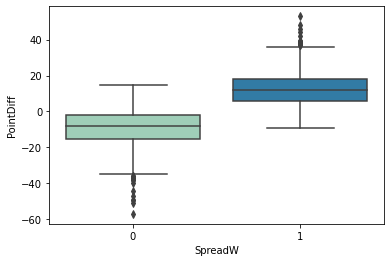

In [117]:
sns.boxplot(x = FinalDF['SpreadW'], y=FinalDF['PointDiff'], palette='YlGnBu')

<AxesSubplot:xlabel='SpreadW', ylabel='Home_Score'>

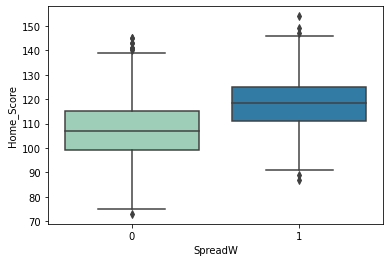

In [120]:
sns.boxplot(x = FinalDF['SpreadW'], y = FinalDF['Home_Score'],palette = 'YlGnBu')


<AxesSubplot:xlabel='Home_Score', ylabel='Visitor_Score'>

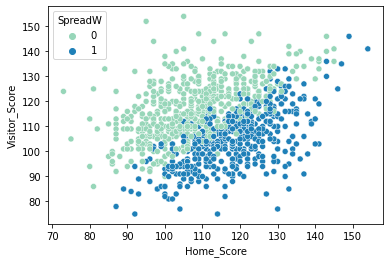

In [122]:
sns.scatterplot(x = FinalDF.Home_Score, y = FinalDF.Visitor_Score, hue = FinalDF['SpreadW'], palette = 'YlGnBu')

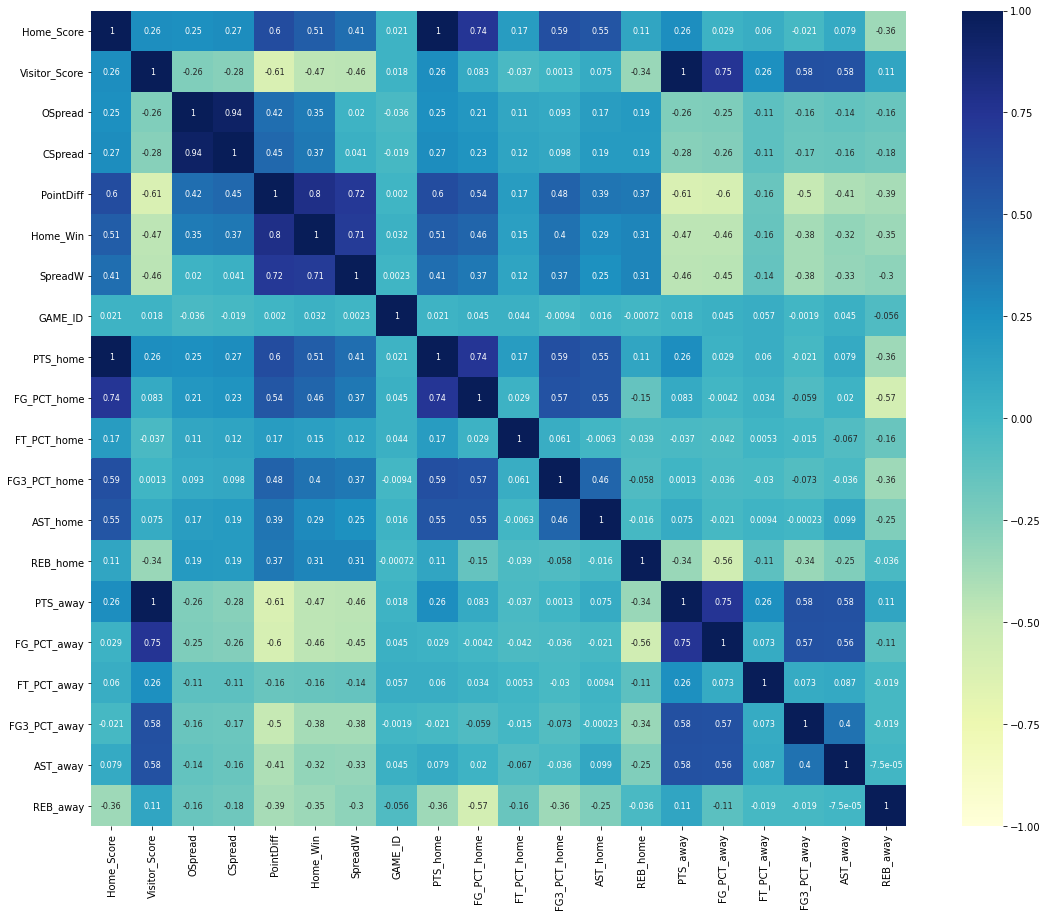

In [124]:
nba_corr = FinalDF.corr()
plt.subplots(figsize=(20,15))

corr = nba_corr
c1 = corr.abs().unstack()
c1.sort_values(ascending = False)

sns.heatmap(corr, 
    annot=True, 
    annot_kws={"fontsize":8},
    xticklabels = nba_corr.columns.values, # x labels
    yticklabels = nba_corr.columns.values, # y labels
    vmin = -1, # color scale the min value
    vmax = 1, # color scale the max
    center = 0, # color scale place at the center at 0
    cmap = "YlGnBu", # color palette
    square = True) # each cell will be square-shaped
plt.show();

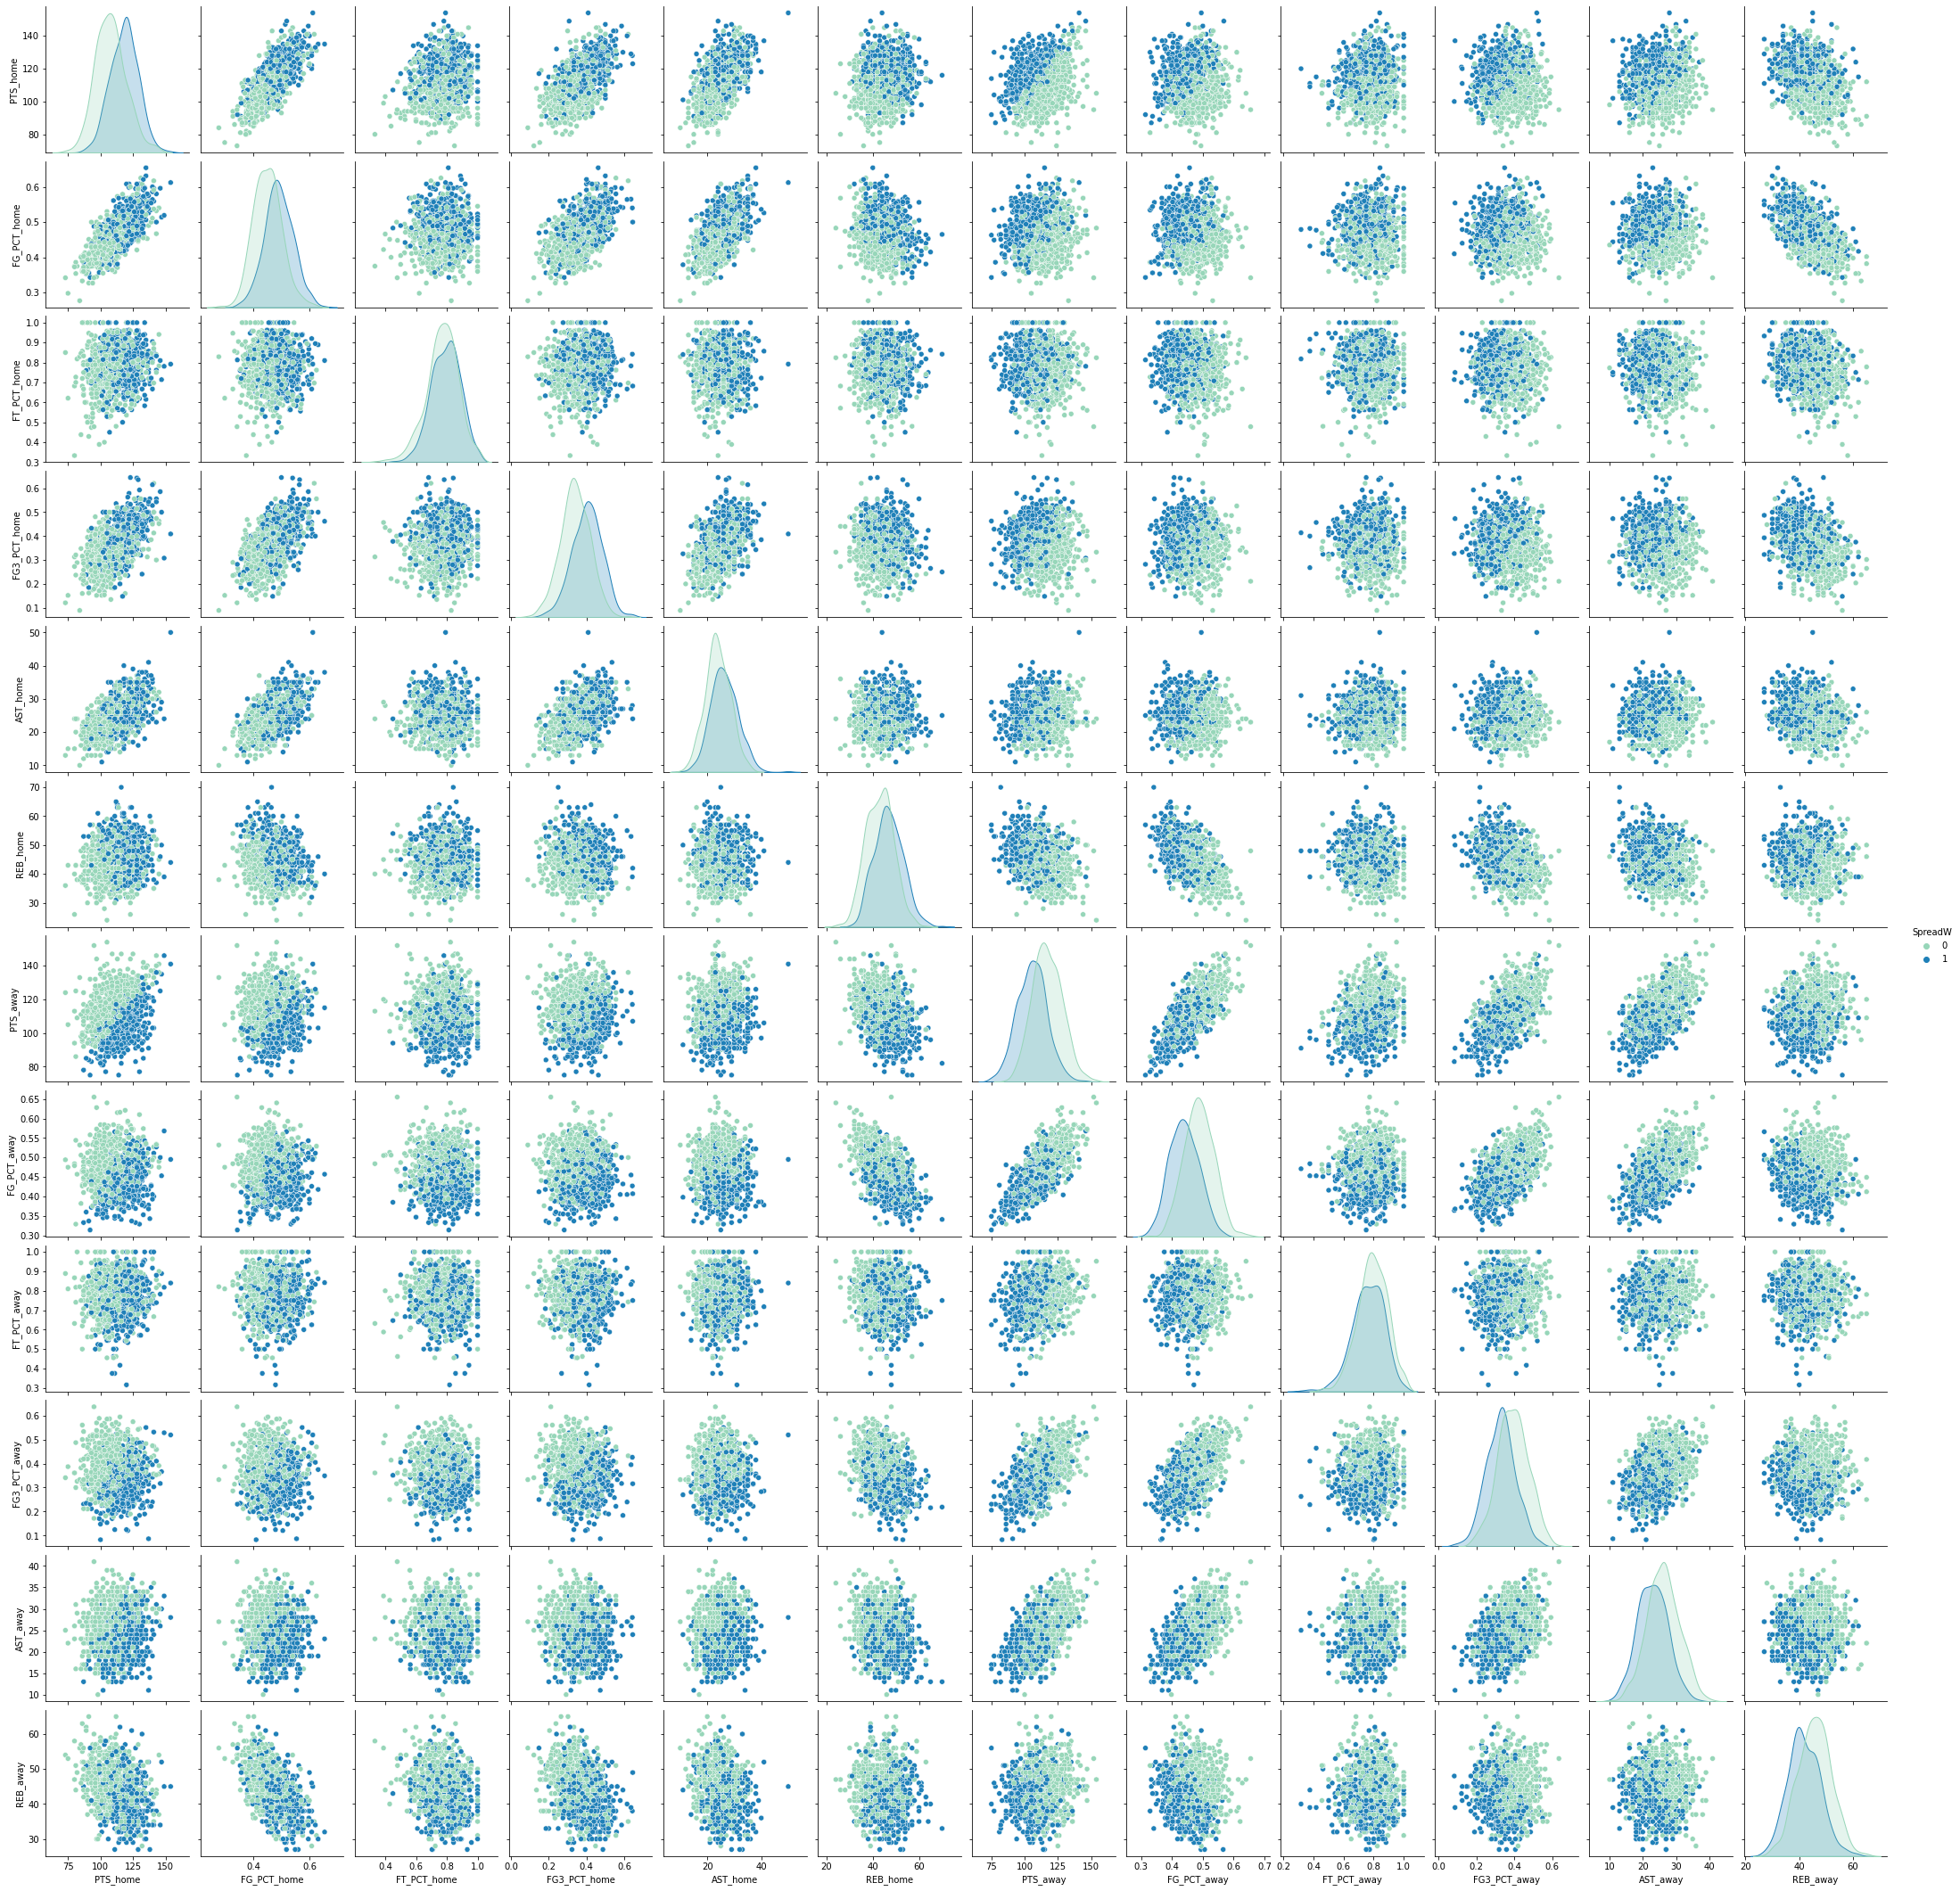

In [134]:

#Pairplot showing the relationship between selected features and SpreadWin

pair_plt_stats = FinalDF[['PTS_home', 'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home',
       'AST_home', 'REB_home', 'PTS_away', 'FG_PCT_away', 'FT_PCT_away',
       'FG3_PCT_away', 'AST_away', 'REB_away','SpreadW']]

sns.pairplot(pair_plt_stats, hue = 'SpreadW', palette = 'YlGnBu')

# plt.savefig('nba_pair_plt.png')
plt.show();

# Feature Engineering 

Creating Features for the last 5 games average 

In [244]:
FinalDF["Last_5_Home_PPG"] = FinalDF.groupby('Home_Team')['Home_Score'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_PPG"] = FinalDF.groupby('Visitor_Team')['Visitor_Score'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_APG"] = FinalDF.groupby('Home_Team')['AST_home'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_APG"] = FinalDF.groupby('Visitor_Team')['AST_away'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_RPG"] = FinalDF.groupby('Home_Team')['REB_home'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_RPG"] = FinalDF.groupby('Visitor_Team')['REB_away'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_FGP"] = FinalDF.groupby('Home_Team')['FG_PCT_home'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_FGP"] = FinalDF.groupby('Visitor_Team')['FG_PCT_away'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_3PTP"] = FinalDF.groupby('Home_Team')['FG3_PCT_home'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_3PTP"] = FinalDF.groupby('Visitor_Team')['FG3_PCT_away'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_FTP"] = FinalDF.groupby('Home_Team')['FT_PCT_home'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_FTP"] = FinalDF.groupby('Visitor_Team')['FT_PCT_away'].transform(lambda s: s.shift().rolling(5).mean())

FinalDF["Last_5_Home_PAllowed"] = FinalDF.groupby('Home_Team')['Visitor_Score'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_PAllowed"] = FinalDF.groupby('Visitor_Team')['Home_Score'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_RAllowed"] = FinalDF.groupby('Home_Team')['REB_away'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_RAllowed"] = FinalDF.groupby('Visitor_Team')['REB_home'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_AAllowed"] = FinalDF.groupby('Home_Team')['AST_away'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_AAllowed"] = FinalDF.groupby('Visitor_Team')['AST_home'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_3PTP_Against"] = FinalDF.groupby('Home_Team')['FG3_PCT_away'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_3PTP_Against"] = FinalDF.groupby('Visitor_Team')['FG3_PCT_home'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Away_Opponent_FTP"] = FinalDF.groupby('Home_Team')['FT_PCT_away'].transform(lambda s: s.shift().rolling(5).mean())
FinalDF["Last_5_Home_Opponent_FTP"] = FinalDF.groupby('Visitor_Team')['FT_PCT_home'].transform(lambda s: s.shift().rolling(5).mean())


Fill Nan's with the average of each team for the year

In [245]:
FinalDF['Last_5_Home_PPG'] = FinalDF['Last_5_Home_PPG'].fillna(FinalDF.groupby('Home_Team')['Home_Score'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_PPG"] = FinalDF['Last_5_Away_PPG'].fillna(FinalDF.groupby('Visitor_Team')['Visitor_Score'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_APG"] = FinalDF['Last_5_Home_APG'].fillna(FinalDF.groupby('Home_Team')['AST_home'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_APG"] = FinalDF['Last_5_Away_APG'].fillna(FinalDF.groupby('Visitor_Team')['AST_away'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_RPG"] = FinalDF['Last_5_Home_RPG'].fillna(FinalDF.groupby('Home_Team')['REB_home'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_RPG"] = FinalDF['Last_5_Away_RPG'].fillna(FinalDF.groupby('Visitor_Team')['REB_away'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_FGP"] = FinalDF['Last_5_Home_FGP'].fillna(FinalDF.groupby('Home_Team')['FG_PCT_home'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_FGP"] = FinalDF['Last_5_Away_FGP'].fillna(FinalDF.groupby('Visitor_Team')['FG_PCT_away'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_3PTP"] = FinalDF['Last_5_Home_3PTP'].fillna(FinalDF.groupby('Home_Team')['FG3_PCT_home'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_3PTP"] = FinalDF['Last_5_Away_3PTP'].fillna(FinalDF.groupby('Visitor_Team')['FG3_PCT_away'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_FTP"] = FinalDF['Last_5_Away_FTP'].fillna(FinalDF.groupby('Home_Team')['FT_PCT_home'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_FTP"] = FinalDF['Last_5_Away_FTP'].fillna(FinalDF.groupby('Visitor_Team')['FT_PCT_away'].transform(lambda s: s.mean()))

FinalDF["Last_5_Home_PAllowed"] = FinalDF['Last_5_Home_PAllowed'].fillna(FinalDF.groupby('Home_Team')['Visitor_Score'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_PAllowed"] = FinalDF['Last_5_Away_PAllowed'].fillna(FinalDF.groupby('Visitor_Team')['Home_Score'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_RAllowed"] =FinalDF['Last_5_Home_RAllowed'].fillna(FinalDF.groupby('Home_Team')['REB_away'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_RAllowed"] = FinalDF['Last_5_Away_RAllowed'].fillna(FinalDF.groupby('Visitor_Team')['REB_home'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_3PTP_Against"] = FinalDF['Last_5_Home_3PTP_Against'].fillna(FinalDF.groupby('Home_Team')['FG3_PCT_away'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_3PTP_Against"] = FinalDF['Last_5_Away_3PTP_Against'].fillna(FinalDF.groupby('Visitor_Team')['FG3_PCT_home'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_AAllowed"] = FinalDF['Last_5_Home_AAllowed'].fillna(FinalDF.groupby('Home_Team')['AST_away'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_AAllowed"] = FinalDF['Last_5_Away_AAllowed'].fillna(FinalDF.groupby('Visitor_Team')['AST_home'].transform(lambda s: s.mean()))
FinalDF["Last_5_Away_Opponent_FTP"] = FinalDF['Last_5_Away_Opponent_FTP'].fillna(FinalDF.groupby('Home_Team')['FT_PCT_away'].transform(lambda s: s.mean()))
FinalDF["Last_5_Home_Opponent_FTP"] = FinalDF['Last_5_Home_Opponent_FTP'].fillna(FinalDF.groupby('Visitor_Team')['FT_PCT_home'].transform(lambda s: s.mean()))



In [246]:
FinalDF[FinalDF['Home_Team'] == 'Nets']

Home_Team   Visitor_Team  Home_Score  Visitor_Score  OSpread  CSpread  \
0         Nets       Warriors         125             99      5.5      7.5   
39        Nets      Grizzlies         111            116      7.0     -1.5   
56        Nets          Hawks         145            141      6.5      5.5   
70        Nets          Hawks          96            114      6.0      6.0   
84        Nets        Wizards         122            123      8.5      7.5   
100       Nets           Jazz         130             96      3.0     -4.5   
116       Nets          76ers         122            109     -3.0     -4.0   
141       Nets        Thunder         116            129      9.5      8.0   
155       Nets        Nuggets         122            116      0.0      1.5   
179       Nets          Magic         122            115      9.5      9.0   
195       Nets          Bucks         125            123     -2.0     -4.0   
225       Nets           Heat         128            124      8.5      7.5   
241       Nets           Heat          98             85      7.5      7.0   
300       Nets       Clippers         124            120      1.5     -1.5   
323       Nets        Raptors         117            123      5.5      5.0   
360       Nets         Pacers         104             94      3.0     -1.5   
457       Nets          Kings         127            118      8.5      5.5   
472       Nets          Magic         129             92      8.0      8.5   
492       Nets      Mavericks          98            115      4.0     -1.0   
536       Nets        Celtics         121            109      3.5      2.5   
554       Nets        Pistons         100             95     11.5     11.0   
572       Nets         Knicks         117            112      7.5      8.5   
620       Nets        Wizards         113            106      8.5      9.0   
681       Nets   Timberwolves         112            107     11.0     10.5   
697       Nets        Rockets         120            108     14.0     12.5   
707       Nets        Hornets         111             89      3.5      2.5   
739       Nets         Knicks         114            112      5.5      6.0   
755       Nets       Pelicans         139            111     10.5      8.5   
777       Nets         Lakers         101            126     12.0     11.0   
829       Nets        Hornets         130            115     11.5     12.0   
882       Nets        Celtics         109            104      4.5      3.5   
898       Nets           Suns         128            119      2.5      1.0   
941       Nets  Trail Blazers         109            128      0.0     -3.0   
1037      Nets          Spurs         128            116      5.0      5.0   
1064      Nets          Bulls         105             91     11.5     11.0   
1069      Nets      Cavaliers         123            109     12.5     13.0   

      PointDiff  Home_Win  SpreadW GAME_DATE_EST   GAME_ID  PTS_home  \
0            26         1        1    2020-12-22  22000001     125.0   
39           -5         0        0    2020-12-28  22000042     111.0   
56            4         1        0    2020-12-30  22000057     145.0   
70          -18         0        0    2021-01-01  22000072      96.0   
84           -1         0        0    2021-01-03  22000086     122.0   
100          34         1        1    2021-01-05  22000102     130.0   
116          13         1        1    2021-01-07  22000118     122.0   
141         -13         0        0    2021-01-10  22000143     116.0   
155           6         1        1    2021-01-12  22000158     122.0   
179           7         1        0    2021-01-16  22000190     122.0   
195           2         1        1    2021-01-18  22000209     125.0   
225           4         1        0    2021-01-23  22000244     128.0   
241          13         1        1    2021-01-25  22000260      98.0   
300           4         1        1    2021-02-02  22000324     124.0   
323          -6         0        0    

In [234]:
pd.set_option('display.max_columns', None)


Dummying the category variables of team names

In [247]:
NBA = pd.get_dummies(FinalDF, columns=['Home_Team','Visitor_Team'])

In [248]:
NBA.columns

Index(['Home_Score', 'Visitor_Score', 'OSpread', 'CSpread', 'PointDiff',
       'Home_Win', 'SpreadW', 'GAME_DATE_EST', 'GAME_ID', 'PTS_home',
       ...
       'Visitor_Team_Pistons', 'Visitor_Team_Raptors', 'Visitor_Team_Rockets',
       'Visitor_Team_Spurs', 'Visitor_Team_Suns', 'Visitor_Team_Thunder',
       'Visitor_Team_Timberwolves', 'Visitor_Team_Trail Blazers',
       'Visitor_Team_Warriors', 'Visitor_Team_Wizards'],
      dtype='object', length=103)

### train test splitting the data

In [366]:
X = NBA.drop(columns=['Home_Score','Visitor_Score','GAME_DATE_EST','PointDiff','PTS_home',
       'FG_PCT_home', 'FT_PCT_home', 'FG3_PCT_home', 'AST_home', 'REB_home',
       'PTS_away', 'FG_PCT_away', 'FT_PCT_away', 'FG3_PCT_away', 'AST_away',
       'REB_away','GAME_ID','Home_Win', 'SpreadW'
                     ])
y = NBA['SpreadW']


In [367]:
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42,test_size=.25,shuffle=True)


## Baseline Model

In [454]:
dummy_model = DummyClassifier()

In [455]:
dummy_model.fit(X_train, y_train)

DummyClassifier()

In [456]:
y_pred_dummy = dummy_model.predict(X_test)

In [457]:
print(metrics.accuracy_score(y_test, y_pred_dummy))

0.5518518518518518


In [474]:
cross_val_score(dummy_model, X_train, y_train, cv=5)

array([0.46296296, 0.52469136, 0.52469136, 0.45061728, 0.47530864])

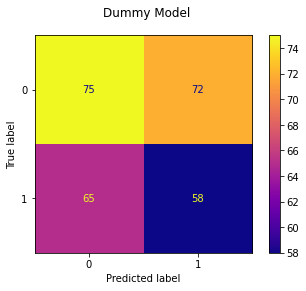

In [460]:
fig, ax = plt.subplots()
fig.suptitle('Dummy Model')
plot_confusion_matrix(dummy_model, y_pred_dummy, y_test, ax=ax, cmap="plasma");

## logistic regression

In [465]:
lm = LogisticRegression(random_state=42)

In [466]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_sc=scaler.transform(X_train)
X_test_sc=scaler.transform(X_test)

In [468]:
lm.fit(X_train_sc, y_train)

LogisticRegression(random_state=42)

In [469]:
lm.score(X_train_sc,y_train)

0.6592592592592592

In [470]:
lm.score(X_test_sc,y_test)

0.5370370370370371

In [472]:
y_pred_lm = lm.predict(X_test_sc)
cm = confusion_matrix(y_test, y_pred_lm)
cm

array([[91, 56],
       [69, 54]])

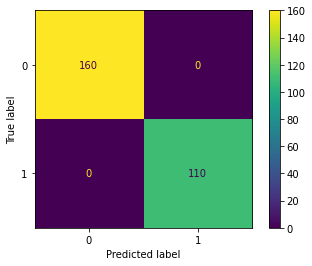

In [473]:
plot_confusion_matrix(lm,X_test_sc,y_pred_lm)

In [375]:
def metrics_score(train_preds, y_train, test_preds, y_test):
    print(f"Training Accuracy:\t{accuracy_score(y_train, train_preds):.4}",
          f"\tTesting Accuracy:\t{accuracy_score(y_test, test_preds):.4}")
    print(f"Training Precision:\t{precision_score(y_train, train_preds):.4}",
          f"\tTesting Precision:\t{precision_score(y_test, test_preds):.4}")
    print(f"Training Recall:\t{recall_score(y_train, train_preds):.4}",
          f"\tTesting Recall:\t\t{recall_score(y_test, test_preds):.4}")
    print(f"Training F1:\t\t{f1_score(y_train, train_preds):.4}",
          f"\tTesting F1:\t\t{f1_score(y_test, test_preds):.4}")

In [376]:
lm_train_preds = lm.predict(X_train)
lm_test_preds = lm.predict(X_test)
metrics_score(lm_train_preds, y_train, lm_test_preds, y_test)

Training Accuracy:	0.621 	Testing Accuracy:	0.5037
Training Precision:	0.6094 	Testing Precision:	0.4486
Training Recall:	0.5172 	Testing Recall:		0.3902
Training F1:		0.5595 	Testing F1:		0.4174


Close training and testing accuracy means unlikely for overfitting

In [377]:
cv_results = cross_validate(
    estimator = model,
    X = X_train,
    y = y_train,
    cv = 5,
    return_train_score = True
)

In [378]:
cv_results['train_score']

array([0.58487654, 0.63580247, 0.6404321 , 0.63425926, 0.63425926])

In [379]:
cv_results['test_score']

array([0.54938272, 0.49382716, 0.5       , 0.5308642 , 0.52469136])

### RFECV

In [385]:
scaler = StandardScaler()
scaler.fit(X_train)

X_test_scaled =  pd.DataFrame(scaler.transform(X_test), index = X_test.index, columns = X_test.columns)
X_train_scaled = pd.DataFrame(scaler.transform(X_train), index = X_train.index, columns = X_train.columns)

In [386]:
rfe_lr = RFECV(estimator=LogisticRegression(class_weight = 'balanced', max_iter = 1000), step = 1, cv = 3, scoring = 'accuracy', n_jobs = -1, verbose = 1)
rfe_lr.fit(X_train_scaled, y_train)
X_train_scaled.columns[rfe_lr.get_support()]


Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 fe

Index(['Last_5_Home_RPG', 'Last_5_Away_3PTP', 'Last_5_Home_FTP',
       'Last_5_Away_FTP', 'Last_5_Away_PAllowed', 'Last_5_Home_3PTP_Against',
       'Last_5_Away_3PTP_Against', 'Home_Team_Hawks', 'Home_Team_Jazz',
       'Home_Team_Knicks', 'Home_Team_Nets', 'Home_Team_Pacers',
       'Home_Team_Rockets', 'Home_Team_Suns', 'Home_Team_Thunder',
       'Home_Team_Warriors', 'Visitor_Team_Spurs', 'Visitor_Team_Warriors'],
      dtype='object')

In [387]:
cross_val_score(rfe_lr, X_train_scaled, y_train, cv=3)

Fitting estimator with 84 features.
Fitting estimator with 83 features.
Fitting estimator with 82 features.
Fitting estimator with 81 features.
Fitting estimator with 80 features.
Fitting estimator with 79 features.
Fitting estimator with 78 features.
Fitting estimator with 77 features.
Fitting estimator with 76 features.
Fitting estimator with 75 features.
Fitting estimator with 74 features.
Fitting estimator with 73 features.
Fitting estimator with 72 features.
Fitting estimator with 71 features.
Fitting estimator with 70 features.
Fitting estimator with 69 features.
Fitting estimator with 68 features.
Fitting estimator with 67 features.
Fitting estimator with 66 features.
Fitting estimator with 65 features.
Fitting estimator with 64 features.
Fitting estimator with 63 features.
Fitting estimator with 62 features.
Fitting estimator with 61 features.
Fitting estimator with 60 features.
Fitting estimator with 59 features.
Fitting estimator with 58 features.
Fitting estimator with 57 fe

array([0.53333333, 0.51481481, 0.51481481])

In [388]:
selected_rfe = X_train_scaled.columns[rfe_lr.support_]
removed_rfe = X_train_scaled.columns[~rfe_lr.support_]

In [389]:
#instantiate a logistic regression object
lr_rfe = LogisticRegression(class_weight = 'balanced')

#fit the linear regression to the data
lr_rfe = lr_rfe.fit(X_train_scaled[selected_rfe], y_train)

#Use the model to predict on the training and test set
y_rfe = lr_rfe.predict(X_train_scaled[selected_rfe])

In [390]:
y_train_pred_rfe = lr_rfe.predict(X_train_scaled[selected_rfe])
y_pred_rfe = lr_rfe.predict(X_test_scaled[selected_rfe])

In [391]:
metrics_score(y_train_pred_rfe, y_train, y_pred_rfe, y_test)

Training Accuracy:	0.621 	Testing Accuracy:	0.5333
Training Precision:	0.5902 	Testing Precision:	0.488
Training Recall:	0.6074 	Testing Recall:		0.4959
Training F1:		0.5987 	Testing F1:		0.4919


In [392]:
acc_rfe = accuracy_score(y_test, y_pred_rfe)
prec_rfe = precision_score(y_test, y_pred_rfe)
rec_rfe = recall_score(y_test, y_pred_rfe)
f1_rfe = f1_score(y_test, y_pred_rfe)

results = pd.DataFrame([['LR_RFE Model', acc_rfe, prec_rfe, rec_rfe, f1_rfe]],
               columns = ['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
# results = results.append(rfe_model, ignore_index = True)
results

Model  Accuracy  Precision    Recall  F1 Score
0  LR_RFE Model  0.533333      0.488  0.495935  0.491935

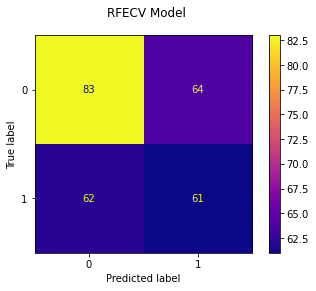

In [393]:
fig, ax = plt.subplots()

fig.suptitle("RFECV Model")

plot_confusion_matrix(rfe_lr, X_test_scaled, y_test, ax=ax, cmap="plasma");

## Logistic, Random Forest , Decision tree Grid search

In [394]:
classifiers = [LogisticRegression(random_state=2021, penalty='none', max_iter = 500), 
              RandomForestClassifier(max_depth = 5, n_estimators = 100),
              DecisionTreeClassifier(max_depth = 5)]

In [395]:
names = ['Logistic Regression', 'Random Forest', 'Decision Tree']


In [396]:
scores = []
for name, clf in zip(names, classifiers):
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)
    scores.append(score)

In [397]:
scores

[0.5148148148148148, 0.5222222222222223, 0.5037037037037037]

In [398]:
param_grid = { 
    'n_estimators': [100, 250],
    "min_samples_leaf": [5, 10, 15],
    'max_leaf_nodes':[20, 35, 50],
}

In [399]:
grid_tree=GridSearchCV(RandomForestClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)


In [400]:
grid_tree.fit(X_train, y_train)


Fitting 5 folds for each of 18 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:    5.0s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_leaf_nodes': [20, 35, 50],
                         'min_samples_leaf': [5, 10, 15],
                         'n_estimators': [100, 250]},
             scoring='accuracy', verbose=1)

In [401]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)
#Identify the best score during fitting with cross-validation

0.5271604938271606
{'max_leaf_nodes': 20, 'min_samples_leaf': 5, 'n_estimators': 100}
RandomForestClassifier(max_leaf_nodes=20, min_samples_leaf=5)


In [402]:
metrics_score(y_train_pred_rfe, y_train, y_pred_rfe, y_test)

Training Accuracy:	0.621 	Testing Accuracy:	0.5333
Training Precision:	0.5902 	Testing Precision:	0.488
Training Recall:	0.6074 	Testing Recall:		0.4959
Training F1:		0.5987 	Testing F1:		0.4919


In [403]:
param_grid = { 
    'criterion': ['gini', 'entropy'],
    'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20, None],
    'max_features': ['auto', None, 25, 100],
    'class_weight': [None, 'balanced']
}

In [404]:
grid_tree=GridSearchCV(DecisionTreeClassifier(), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)


In [405]:
grid_tree.fit(X_train, y_train)


Fitting 5 folds for each of 176 candidates, totalling 880 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  28 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 800 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 880 out of 880 | elapsed:    1.3s finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 4, 6, 8, 10, 12, 14, 16, 18, 20,
                                       None],
                         'max_features': ['auto', None, 25, 100]},
             scoring='accuracy', verbose=1)

In [406]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)
#Identify the best score during fitting with cross-validation


0.5481481481481482
{'class_weight': None, 'criterion': 'entropy', 'max_depth': 8, 'max_features': 'auto'}
DecisionTreeClassifier(criterion='entropy', max_depth=8, max_features='auto')


In [407]:
import xgboost

In [408]:
param_grid = { 
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, None],
    'booster': ['gbtree', 'gblinear', 'dart']
}


In [409]:
grid_tree=GridSearchCV(xgboost.XGBClassifier(objective='binary:logistic'), param_grid, cv=5, scoring='accuracy', verbose=1, n_jobs=-1)

In [410]:
grid_tree.fit(X_train, y_train)


Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 112 out of 135 | elapsed:    3.3s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:    4.4s finished


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None,

In [411]:
# Single best score achieved across all params (min_samples_split)
print(grid_tree.best_score_)

# Dictionary containing the parameters (min_samples_split) used to generate that score
print(grid_tree.best_params_)

# Actual model object fit with those best parameters
# Shows default parameters that we did not specify
print(grid_tree.best_estimator_)
#Identify the best score during fitting with cross-validation

0.5259259259259259
{'booster': 'gbtree', 'max_depth': 5, 'n_estimators': 10}
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=5,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=10, n_jobs=0, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


In [412]:
B_Model = RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=15, n_estimators=250)

In [413]:
B_Model.fit(X_train, y_train)

RandomForestClassifier(max_leaf_nodes=50, min_samples_leaf=15, n_estimators=250)

In [414]:
metrics_score(y_train_pred_rfe, y_train, y_pred_rfe, y_test)

Training Accuracy:	0.621 	Testing Accuracy:	0.5333
Training Precision:	0.5902 	Testing Precision:	0.488
Training Recall:	0.6074 	Testing Recall:		0.4959
Training F1:		0.5987 	Testing F1:		0.4919


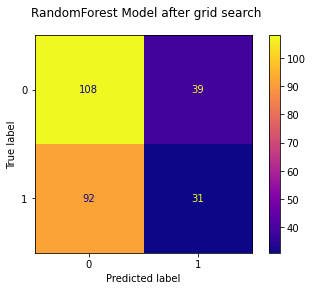

In [415]:
#confusion matrix for test data
fig, ax = plt.subplots()

fig.suptitle("RandomForest Model after grid search")

plot_confusion_matrix(B_Model, X_test, y_test, ax=ax, cmap="plasma");

In [416]:
#accuracy
accuracy_score(y_test, B_Model.predict(X_test))

0.5148148148148148

## K neighbors

In [417]:
st_x= StandardScaler()    
X_train_kn= st_x.fit_transform(X_train)    
X_test_kn= st_x.transform(X_test) 

Text(0, 0.5, 'Error Rate')

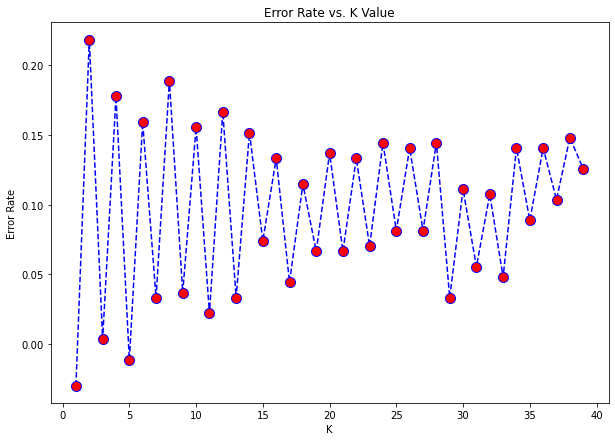

In [418]:
error_rates = []

for a in range(1, 40):
    k = a
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_kn, y_train)
    preds = knn.predict(X_test_kn)
    error_rates.append(np.mean(y_test - preds))

plt.figure(figsize=(10, 7))
plt.plot(range(1,40),error_rates,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [422]:
k = 3
knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train_kn, y_train)
preds = knn.predict(X_test_kn)
x_pred = knn.predict(X_train_kn)

In [423]:
metrics_score(x_pred, y_train, preds, y_test)

Training Accuracy:	0.7617 	Testing Accuracy:	0.4852
Training Precision:	0.7644 	Testing Precision:	0.4344
Training Recall:	0.7056 	Testing Recall:		0.4309
Training F1:		0.7338 	Testing F1:		0.4327


In [424]:
from sklearn.metrics import classification_report

print(confusion_matrix(y_test, preds))
print(classification_report(y_test, preds))

[[78 69]
 [70 53]]
              precision    recall  f1-score   support

           0       0.53      0.53      0.53       147
           1       0.43      0.43      0.43       123

    accuracy                           0.49       270
   macro avg       0.48      0.48      0.48       270
weighted avg       0.48      0.49      0.49       270



# # Pipeline

In [425]:
rf = RandomForestClassifier()
svc = SVC()
logreg = LogisticRegression(max_iter=250)


In [426]:
pipeline=Pipeline(steps=[
    ('std_scaler',StandardScaler()),
    ('VC', VotingClassifier(
                estimators=[('randomforest', rf), ('knn', knn), ('SupportVector', svc),('logistic regression',logreg)], 
                voting='hard'))
])

In [427]:
pipeline.fit(X_train,y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('VC',
                 VotingClassifier(estimators=[('randomforest',
                                               RandomForestClassifier()),
                                              ('knn',
                                               KNeighborsClassifier(n_neighbors=3)),
                                              ('SupportVector', SVC()),
                                              ('logistic regression',
                                               LogisticRegression(max_iter=250))]))])

In [428]:
pipe_y_pred=pipeline.predict(X_test)
pipe_x_pred=pipeline.predict(X_train)

In [429]:
metrics_score(pipe_x_pred, y_train,pipe_y_pred, y_test)

Training Accuracy:	0.8543 	Testing Accuracy:	0.5222
Training Precision:	0.9544 	Testing Precision:	0.4615
Training Recall:	0.7215 	Testing Recall:		0.2927
Training F1:		0.8218 	Testing F1:		0.3582


In [430]:
cv_results = cross_validate(
    estimator = pipeline,
    X = X_train,
    y = y_train,
    cv = 5,
    return_train_score = True
)

In [431]:
cv_results['train_score']

array([0.86882716, 0.86265432, 0.875     , 0.87345679, 0.8595679 ])

In [432]:
cv_results['test_score']

array([0.58024691, 0.53703704, 0.47530864, 0.55555556, 0.50617284])

# Logistic regression gridsearch

In [433]:
scoring = ['neg_log_loss', 'accuracy']


In [434]:
log_pipeline = Pipeline(steps=[('std_scaler',StandardScaler()),
                      ('logisticregression', LogisticRegression(max_iter=1000))])

#paramters to test with the grid search
log_params = {'logisticregression__solver' : ['liblinear', 'lbfgs', 'newton-cg'],
                'logisticregression__penalty': ['l1', 'l2'],
                'logisticregression__C': [.00001, .0001, .001, .01, .05, 0.1],
                'logisticregression__class_weight': [None] }

log_cv = GridSearchCV(log_pipeline, param_grid=log_params, cv=5,scoring=scoring, refit = 'neg_log_loss',  verbose=1)

In [435]:
log_pipeline.fit(X_train,y_train)

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [436]:
logpipe_y_pred=log_pipeline.predict(X_test)
logpipe_x_pred=log_pipeline.predict(X_train)

In [437]:
metrics_score(logpipe_x_pred, y_train,logpipe_y_pred, y_test)

Training Accuracy:	0.6593 	Testing Accuracy:	0.537
Training Precision:	0.6455 	Testing Precision:	0.4909
Training Recall:	0.5942 	Testing Recall:		0.439
Training F1:		0.6188 	Testing F1:		0.4635


In [438]:
cross_val_score(log_pipeline,X_train,y_train,cv=3)

array([0.55555556, 0.52222222, 0.54814815])